In [1]:
import os
import random

# for visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np 
import cv2

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

## create a datagenerator 

In [2]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                         layers.RandomRotation(0.2)])
def load_train_img(filename):
    mapName = '/home/shared/DARPA/all_patched_data/training/line/map_patches/'+filename[0]
    legendName = '/home/shared/DARPA/all_patched_data/training/line/legend/'+filename[1] 

    map_img = tf.io.read_file(mapName) # Read image file
    map_img = tf.cast(tf.io.decode_png(map_img), dtype=tf.float32) / 255.0

    legend_img = tf.io.read_file(legendName) # Read image file
    legend_img = tf.cast(tf.io.decode_png(legend_img), dtype=tf.float32) / 255.0
    
    map_img = tf.concat(axis=2, values = [map_img, legend_img])
    map_img = map_img*2.0 - 1.0 # range(-1.0,1.0)
    map_img = tf.image.resize(map_img, [256, 256])
    
    segName = '/home/shared/DARPA/all_patched_data/training/line/seg_patches/'+filename[0]  
    
    legend_img = tf.io.read_file(segName) # Read image file
    legend_img = tf.io.decode_png(legend_img)
    legend_img = tf.image.resize(legend_img, [256, 256])
    
    return map_img, legend_img
img, seg = load_train_img(['CO_Bailey_fault_line_10_28.png', 'CO_Bailey_fault_line.png'])
#img, seg = load_img('VA_Lahore_bm_thrust_fault_line_402.png')

2022-11-13 17:19:25.079860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13868 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0004:04:00.0, compute capability: 7.0


In [3]:
def load_validation_img(filename):
    
    # filename = ('CO_Boulder_1978_Ysp_poly_18_7.png', 'CO_Boulder_1978_Ysp_poly.png')

    mapName = '/home/shared/DARPA/all_patched_data/validation/line/map_patches/'+filename[0]
    legendName = '/home/shared/DARPA/all_patched_data/validation/line/legend/'+filename[1] 

    map_img = tf.io.read_file(mapName) # Read image file
    map_img = tf.cast(tf.io.decode_png(map_img), dtype=tf.float32) / 255.0

    legend_img = tf.io.read_file(legendName) # Read image file
    legend_img = tf.cast(tf.io.decode_png(legend_img), dtype=tf.float32) / 255.0
    
    map_img = tf.concat(axis=2, values = [map_img, legend_img])
    map_img = map_img*2.0 - 1.0 # range(-1.0,1.0)
    map_img = tf.image.resize(map_img, [256, 256])
    
    segName = '/home/shared/DARPA/all_patched_data/validation/line/seg_patches/'+filename[0]  
    
    legend_img = tf.io.read_file(segName) # Read image file
    legend_img = tf.io.decode_png(legend_img)
    legend_img = tf.image.resize(legend_img, [256, 256])
    legend_img = legend_img
    
    return map_img, legend_img

In [4]:
train_map_file = os.listdir('/home/shared/DARPA/all_patched_data/training/line/map_patches')
train_map_legend_names = [(x, '_'.join(x.split('_')[0:-2])+'.png') for x in train_map_file]

train_dataset = tf.data.Dataset.from_tensor_slices(train_map_legend_names)
train_dataset = train_dataset.map(load_train_img)
train_dataset = train_dataset.shuffle(10000, reshuffle_each_iteration=False).batch(150)

# A peek of how BatchDataset 
# it = iter(train_dataset)
# print(next(it))
validate_map_file = os.listdir('/home/shared/DARPA/all_patched_data/validation/line/map_patches')
validate_map_legend_names = [(x, '_'.join(x.split('_')[0:-2])+'.png') for x in validate_map_file]

validate_dataset = tf.data.Dataset.from_tensor_slices(validate_map_legend_names)
validate_dataset = validate_dataset.map(load_validation_img)
validate_dataset = validate_dataset.batch(50)

## Constructing the U-Net Architecture

### U-Net Encoder Block

In [5]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

### U-Net Decoder Block

In [6]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Compile U-Net Blocks

In [7]:
def UNetCompiled(input_size=(256, 256, 4), n_filters=32, n_classes=1):
    """
       Combine both encoder and decoder blocks according to the U-Net research paper
       Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [8]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(256,256,6), n_filters=16, n_classes=1)

### Compile and Run Model

In [9]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss= tf.keras.losses.binary_crossentropy, #binary_crossentropy, 
              metrics=['accuracy', 'acc'])

In [10]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='./saved_line_model/best_attention_model.hdf5', 
    monitor='loss',
    verbose=1, 
    save_best_only=True,
    save_freq= 100)

In [11]:
# load weight
if os.path.exists("./saved_line_model/best_attention_model.hdf5"):
    unet.load_weights("./saved_line_model/best_attention_model.hdf5")

# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(train_dataset, epochs=5, callbacks=[callback1], validation_data=validate_dataset)

Epoch 1/5


2022-11-13 17:20:09.366966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9553 of 10000
2022-11-13 17:20:11.773540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-11-13 17:20:14.695125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-11-13 17:20:21.391770: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-13 17:20:21.391832: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-13 17:20:21.494366:

 99/187 [==============>...............] - ETA: 1:43 - loss: 0.0107 - accuracy: 0.9952 - acc: 0.9952
Epoch 1: loss improved from inf to 0.01069, saving model to ./saved_line_model/best_attention_model.hdf5
187/187 [==============================] - 248s 1s/step - loss: 0.0106 - accuracy: 0.9953 - acc: 0.9953 - val_loss: 0.0209 - val_accuracy: 0.9945 - val_acc: 0.9945
Epoch 2/5


2022-11-13 17:24:15.679838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8669 of 10000
2022-11-13 17:24:22.395891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 12/187 [>.............................] - ETA: 3:41 - loss: 0.0104 - accuracy: 0.9954 - acc: 0.9954
Epoch 2: loss improved from 0.01069 to 0.01040, saving model to ./saved_line_model/best_attention_model.hdf5
112/187 [================>.............] - ETA: 1:26 - loss: 0.0105 - accuracy: 0.9953 - acc: 0.9953
Epoch 2: loss did not improve from 0.01040
187/187 [==============================] - 238s 1s/step - loss: 0.0105 - accuracy: 0.9953 - acc: 0.9953 - val_loss: 0.0230 - val_accuracy: 0.9945 - val_acc: 0.9945
Epoch 3/5


2022-11-13 17:28:14.010855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8546 of 10000
2022-11-13 17:28:22.610365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 25/187 [===>..........................] - ETA: 2:11 - loss: 0.0105 - accuracy: 0.9953 - acc: 0.9953
Epoch 3: loss did not improve from 0.01040
125/187 [===================>..........] - ETA: 1:03 - loss: 0.0104 - accuracy: 0.9954 - acc: 0.9954
Epoch 3: loss improved from 0.01040 to 0.01038, saving model to ./saved_line_model/best_attention_model.hdf5
187/187 [==============================] - 227s 1s/step - loss: 0.0104 - accuracy: 0.9954 - acc: 0.9954 - val_loss: 0.0236 - val_accuracy: 0.9945 - val_acc: 0.9945
Epoch 4/5


2022-11-13 17:32:10.353332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8385 of 10000
2022-11-13 17:32:11.377101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9468 of 10000
2022-11-13 17:32:11.958351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 38/187 [=====>........................] - ETA: 3:09 - loss: 0.0104 - accuracy: 0.9954 - acc: 0.9954
Epoch 4: loss improved from 0.01038 to 0.01038, saving model to ./saved_line_model/best_attention_model.hdf5
138/187 [=====================>........] - ETA: 57s - loss: 0.0104 - accuracy: 0.9954 - acc: 0.9954
Epoch 4: loss improved from 0.01038 to 0.01037, saving model to ./saved_line_model/best_attention_model.hdf5
187/187 [==============================] - 248s 1s/step - loss: 0.0104 - accuracy: 0.9954 - acc: 0.9954 - val_loss: 0.0237 - val_accuracy: 0.9945 - val_acc: 0.9945
Epoch 5/5


2022-11-13 17:36:09.476585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8845 of 10000
2022-11-13 17:36:19.415416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9797 of 10000
2022-11-13 17:36:20.376519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 51/187 [=======>......................] - ETA: 1:46 - loss: 0.0103 - accuracy: 0.9954 - acc: 0.9954
Epoch 5: loss improved from 0.01037 to 0.01033, saving model to ./saved_line_model/best_attention_model.hdf5
151/187 [=======================>......] - ETA: 36s - loss: 0.0103 - accuracy: 0.9954 - acc: 0.9954
Epoch 5: loss improved from 0.01033 to 0.01033, saving model to ./saved_line_model/best_attention_model.hdf5
187/187 [==============================] - 223s 1s/step - loss: 0.0103 - accuracy: 0.9954 - acc: 0.9954 - val_loss: 0.0260 - val_accuracy: 0.9945 - val_acc: 0.9945


In [12]:
# serialize and save the model that you just trained 
saved_model_path = "./saved_line_model/best_attention_model.hdf5" 
unet.save(saved_model_path)

## Evaluate Model Results

### View Predicted Segmentations

In [13]:
unet.load_weights("./saved_line_model/best_attention_model.hdf5")

In [20]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

In [14]:
def plotResult(n, fileName):
    test_dataset = tf.data.Dataset.from_tensor_slices([fileName])
    test_dataset = test_dataset.map(load_validation_img)
    test_dataset = test_dataset.batch(1)

    predicted = unet.predict(test_dataset)
    
    mapName = '/home/shared/DARPA/all_patched_data/validation/line/map_patches/'+fileName[0]
    segName = '/home/shared/DARPA/all_patched_data/validation/line/seg_patches/'+fileName[0]
    legendName = '/home/shared/DARPA/all_patched_data/validation/line/legend/'+fileName[1]

    map_img = mpimg.imread(mapName)
    seg_img = mpimg.imread(segName)
    
    label_img = mpimg.imread(legendName)
    
    plt.rcParams["figure.figsize"] = (25,10)
    
    plt.subplot(n,5,1)
    plt.title("map")
    plt.imshow(map_img)

    plt.subplot(n,5,2)
    plt.title("legend")
    plt.imshow(label_img)

    plt.subplot(n,5,3)
    plt.title("true segmentation")
    plt.spy(seg_img, markersize=1) 

    plt.subplot(n,5,4)
    plt.title("predicted segmentation")
#     plt.imshow(predicted[0,:,:,0])
    plt.spy(np.where(predicted[0,:,:,0]>0.1,1,0), markersize=1) 
    
    plt.subplot(n,5,5)
    plt.title("predicted segmentation")
    plt.imshow(predicted[0,:,:,0])
#     plt.spy(np.where(predicted[0,:,:,0]>0.5,1,0), markersize=1)

    plt.show()

('OR_Carlton_fault_line_19_6.png', 'OR_Carlton_fault_line.png')


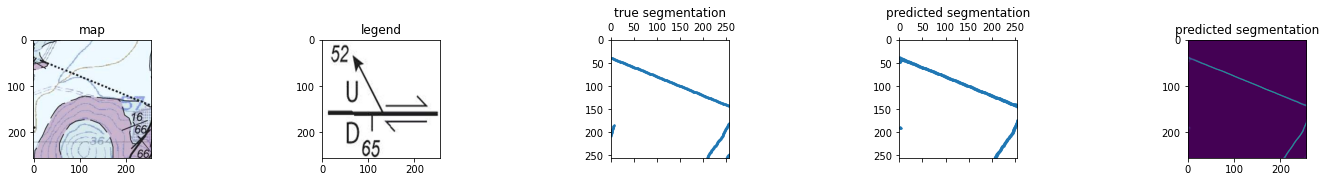

('AZ_PrescottNF_fault_line_16_4.png', 'AZ_PrescottNF_fault_line.png')


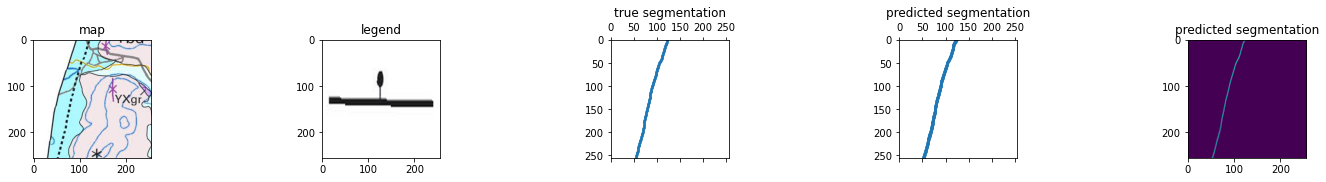

('MN_fault_line_11_20.png', 'MN_fault_line.png')


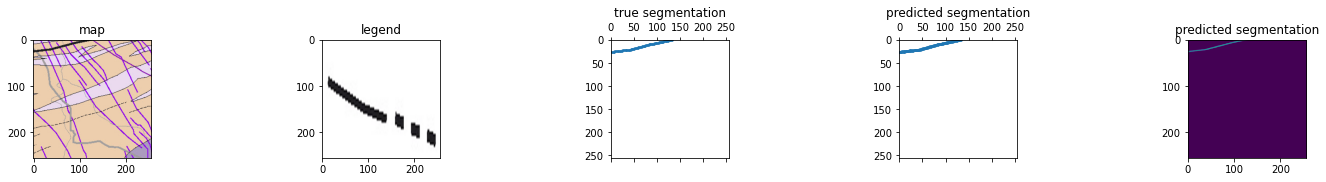

('NV_HiddenHills_gravity_contour_line_22_20.png', 'NV_HiddenHills_gravity_contour_line.png')


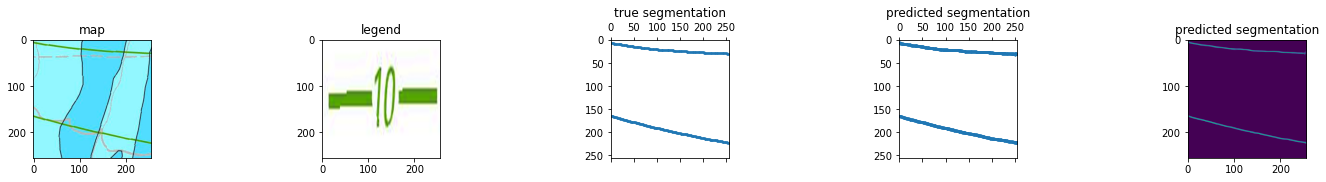

In [22]:
n=4
for fileName in random.sample(validate_map_legend_names, n):
    print(fileName)
    plotResult(n, fileName)